In [12]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [13]:
set.seed(1234)
options(digits=2)
stats <- c()

In [14]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"

    # prj_name = "Screen2_101vecs"
    # # data_subdir_suffixes = "L1,L2,L3,L4"     
    # secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    # save_seurat_h5 = "NO"

}


In [15]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [16]:
integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [17]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 36 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 
Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 
Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 

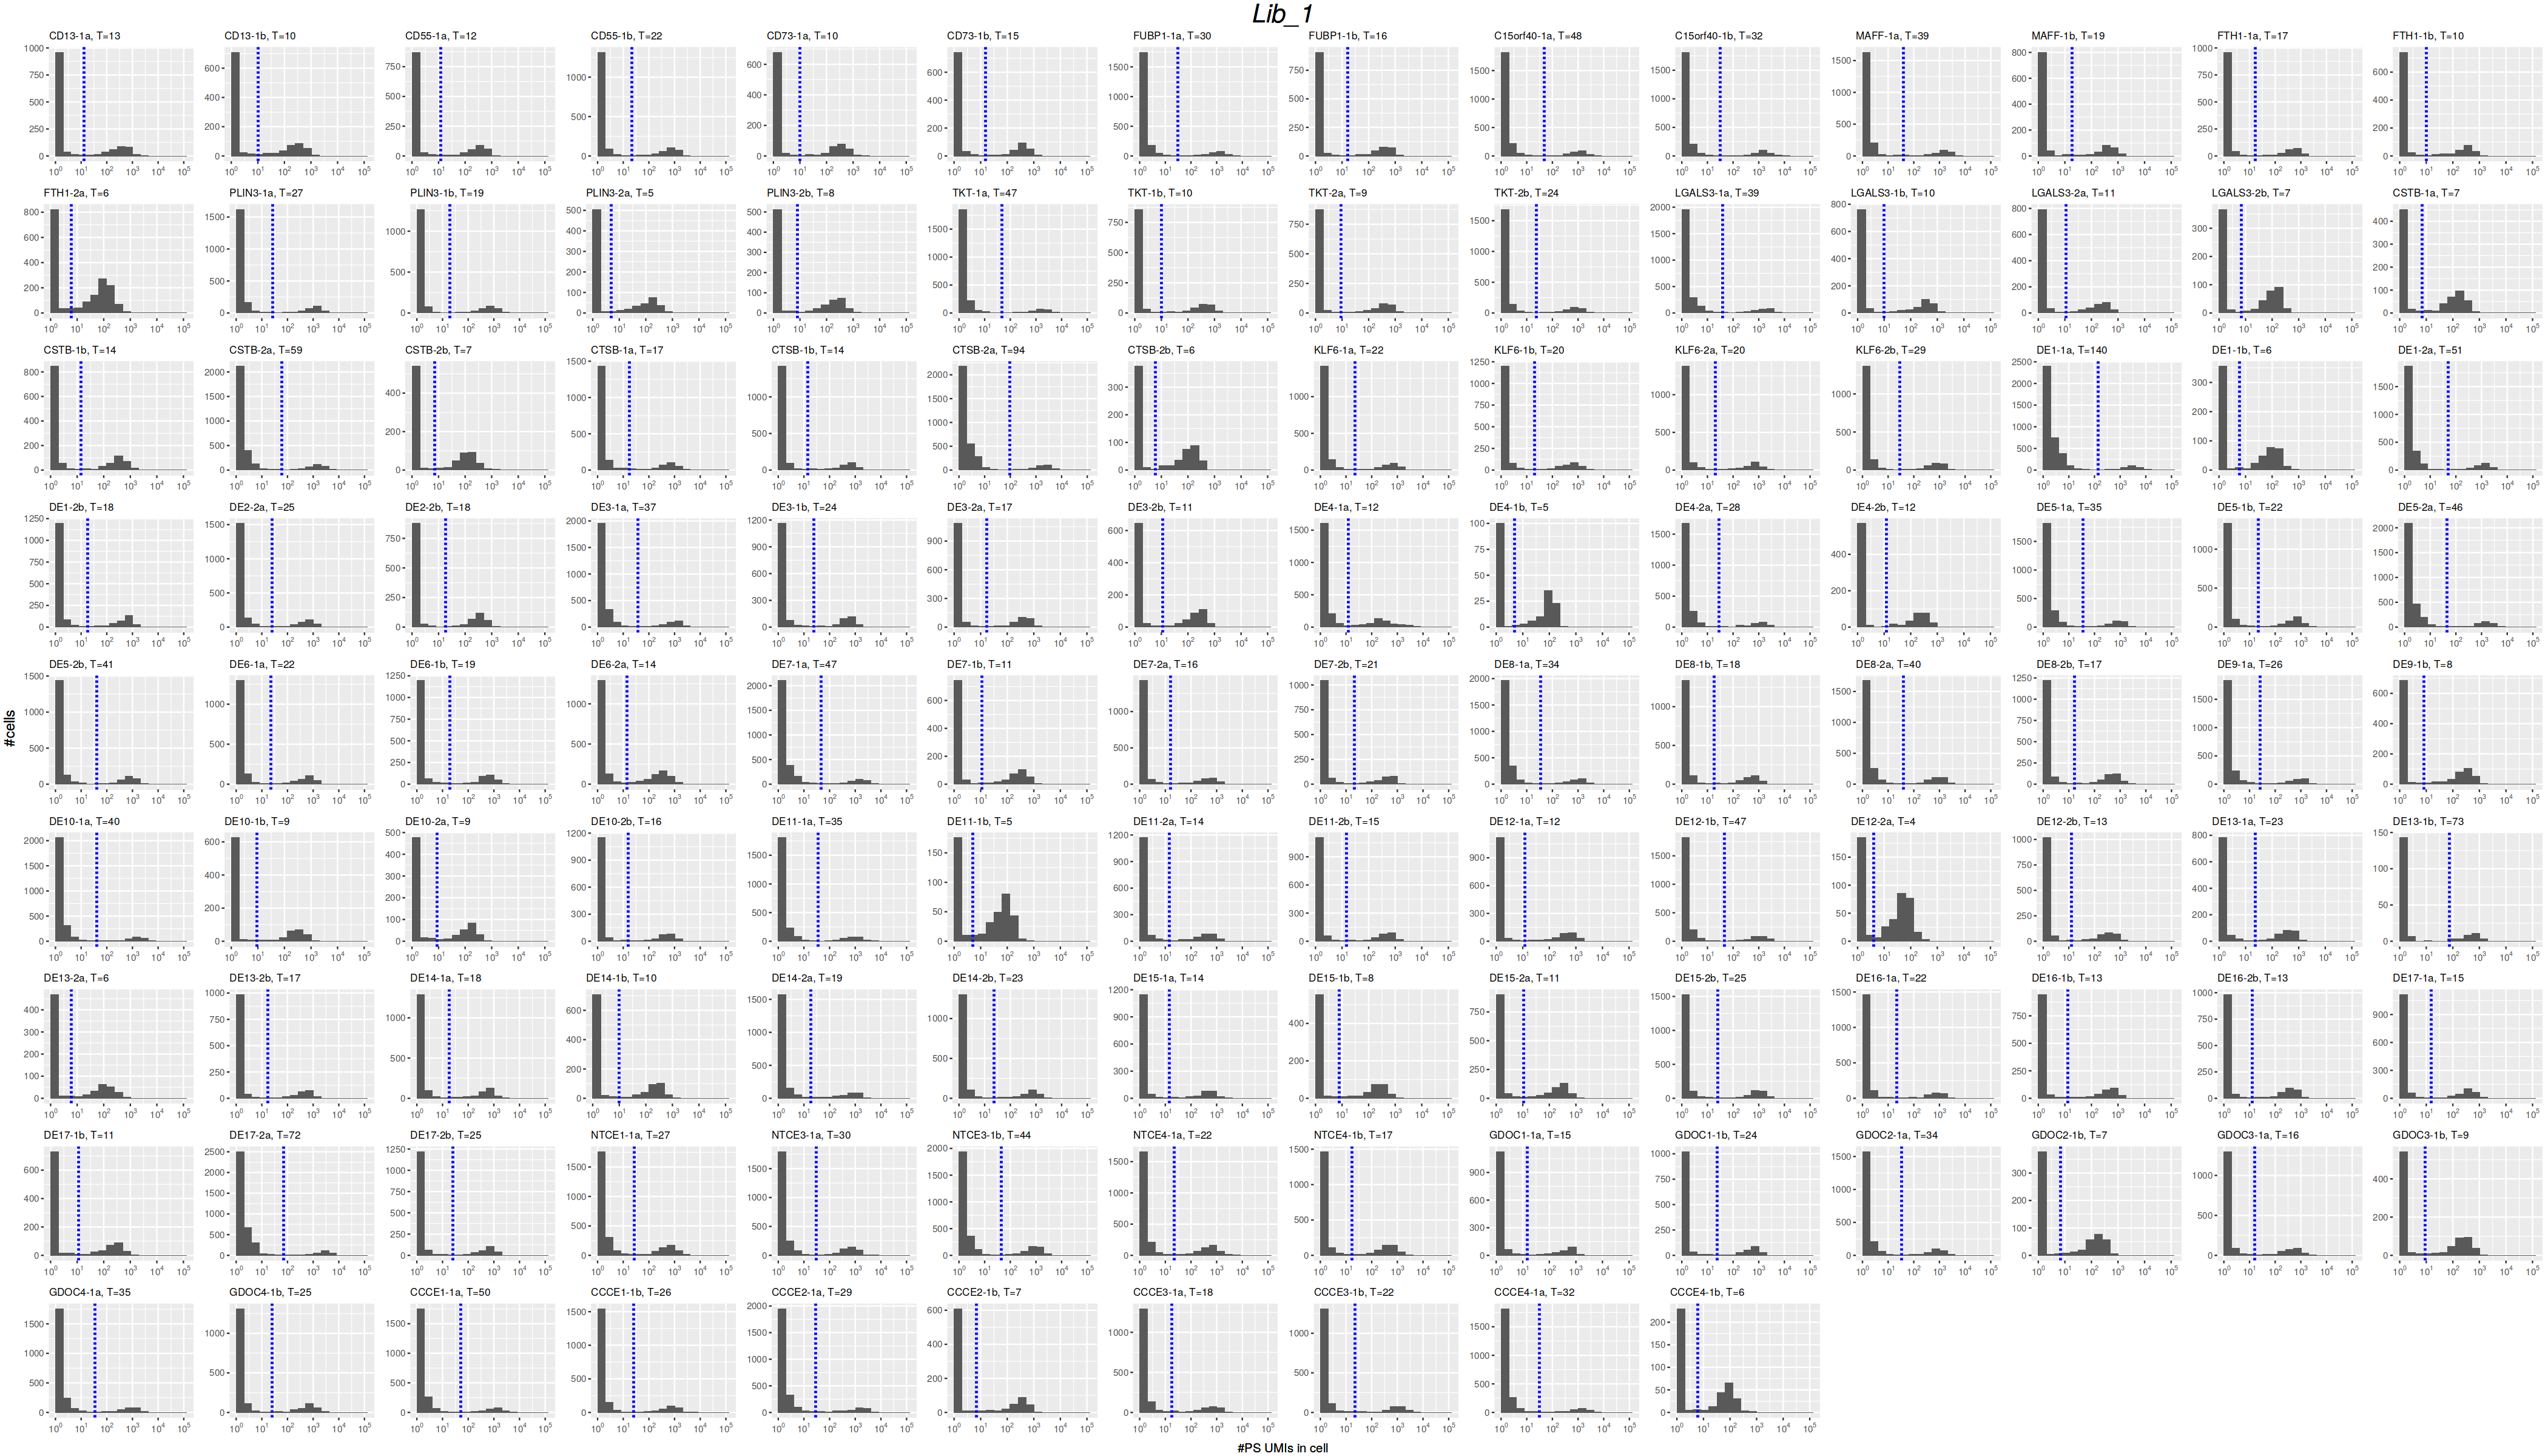

Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 2 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


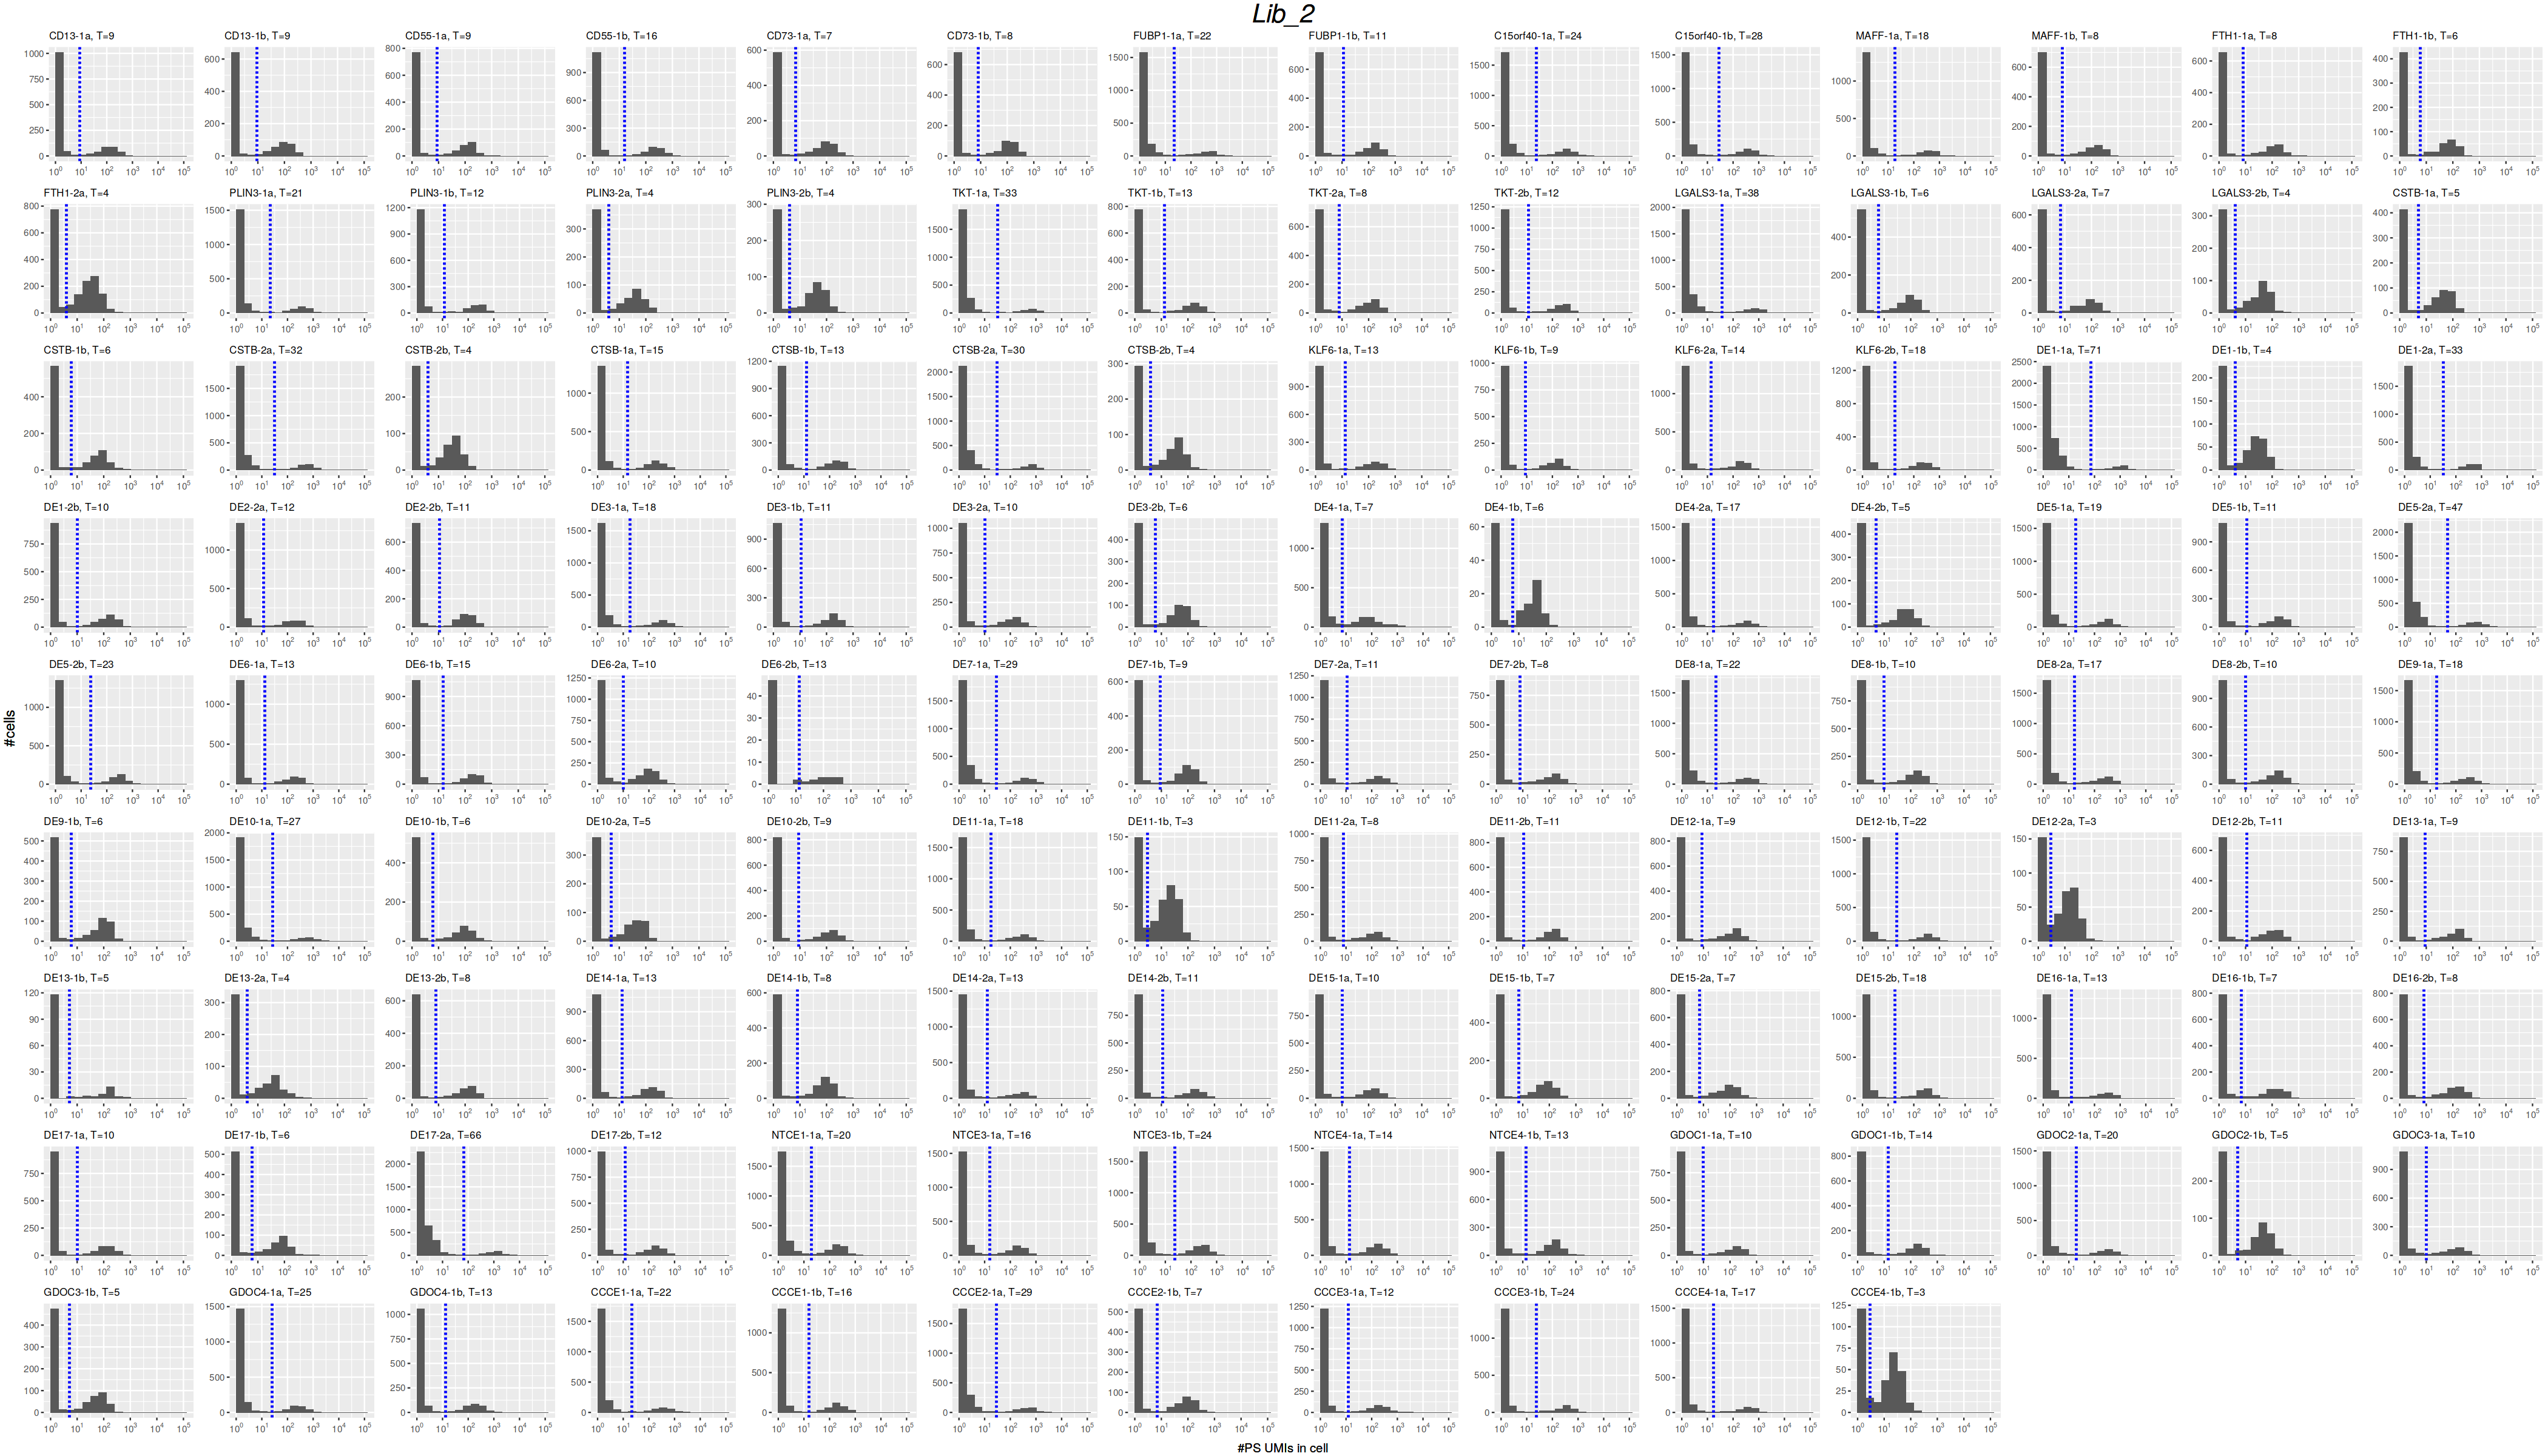

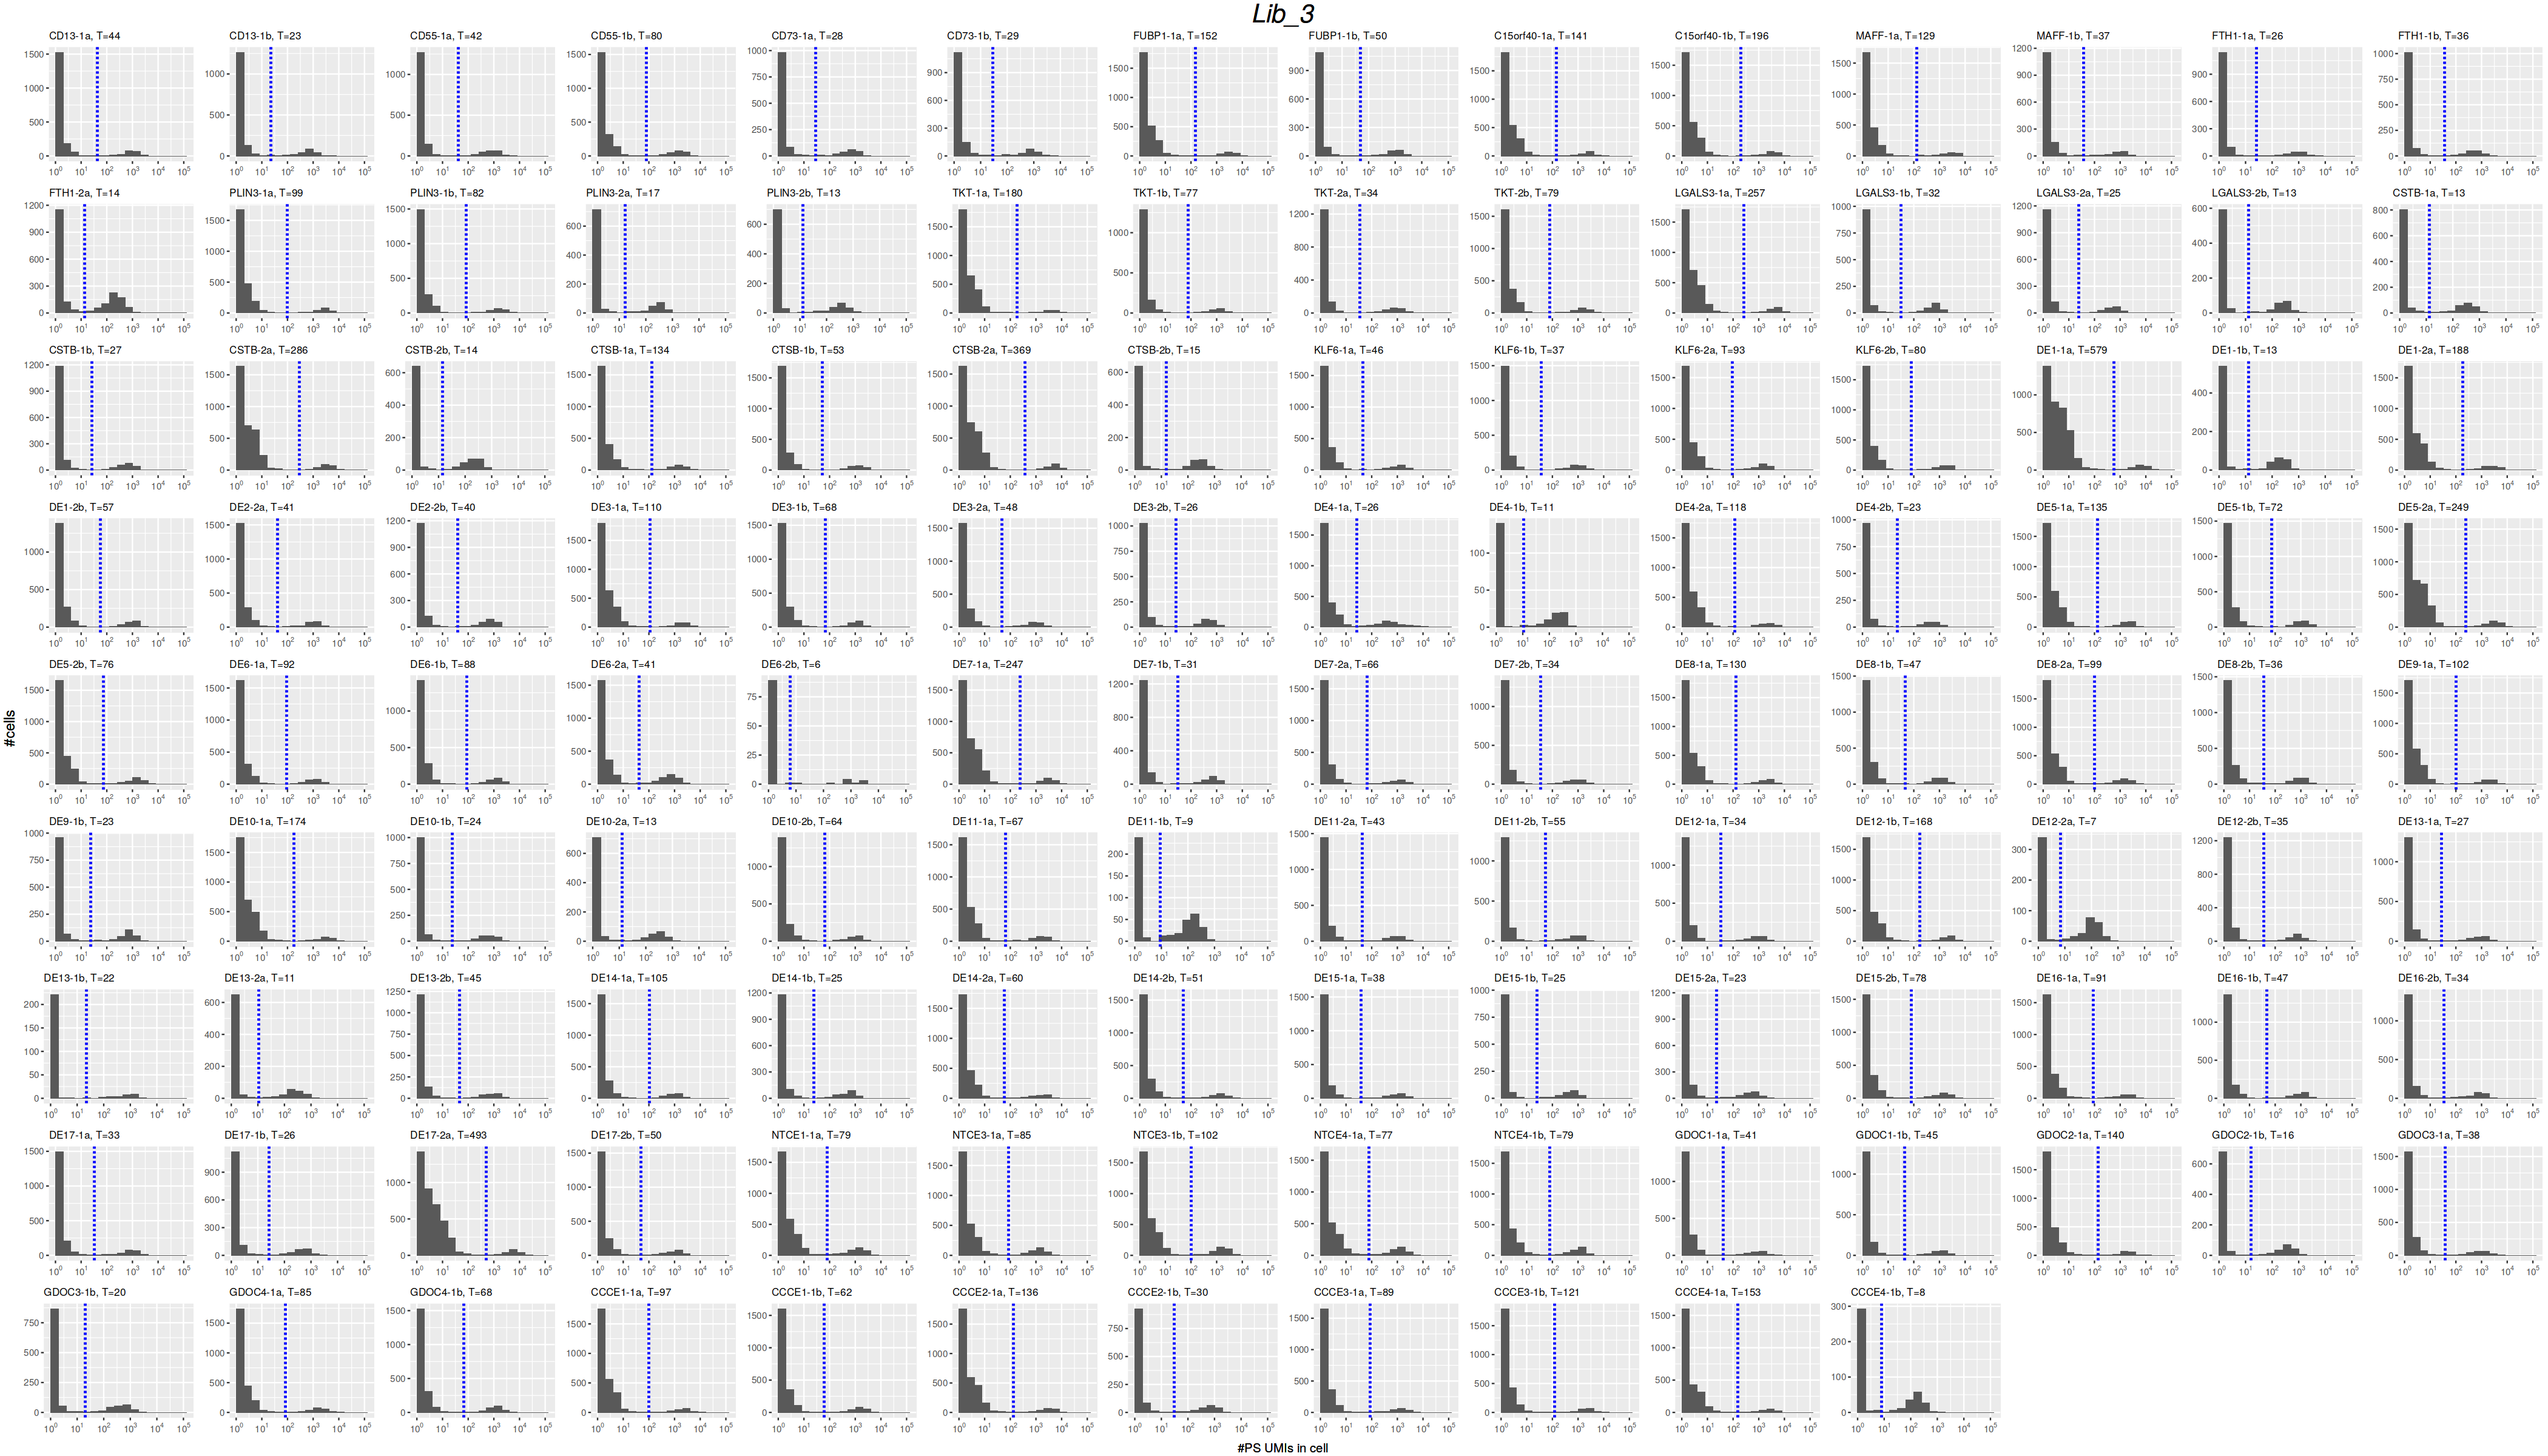

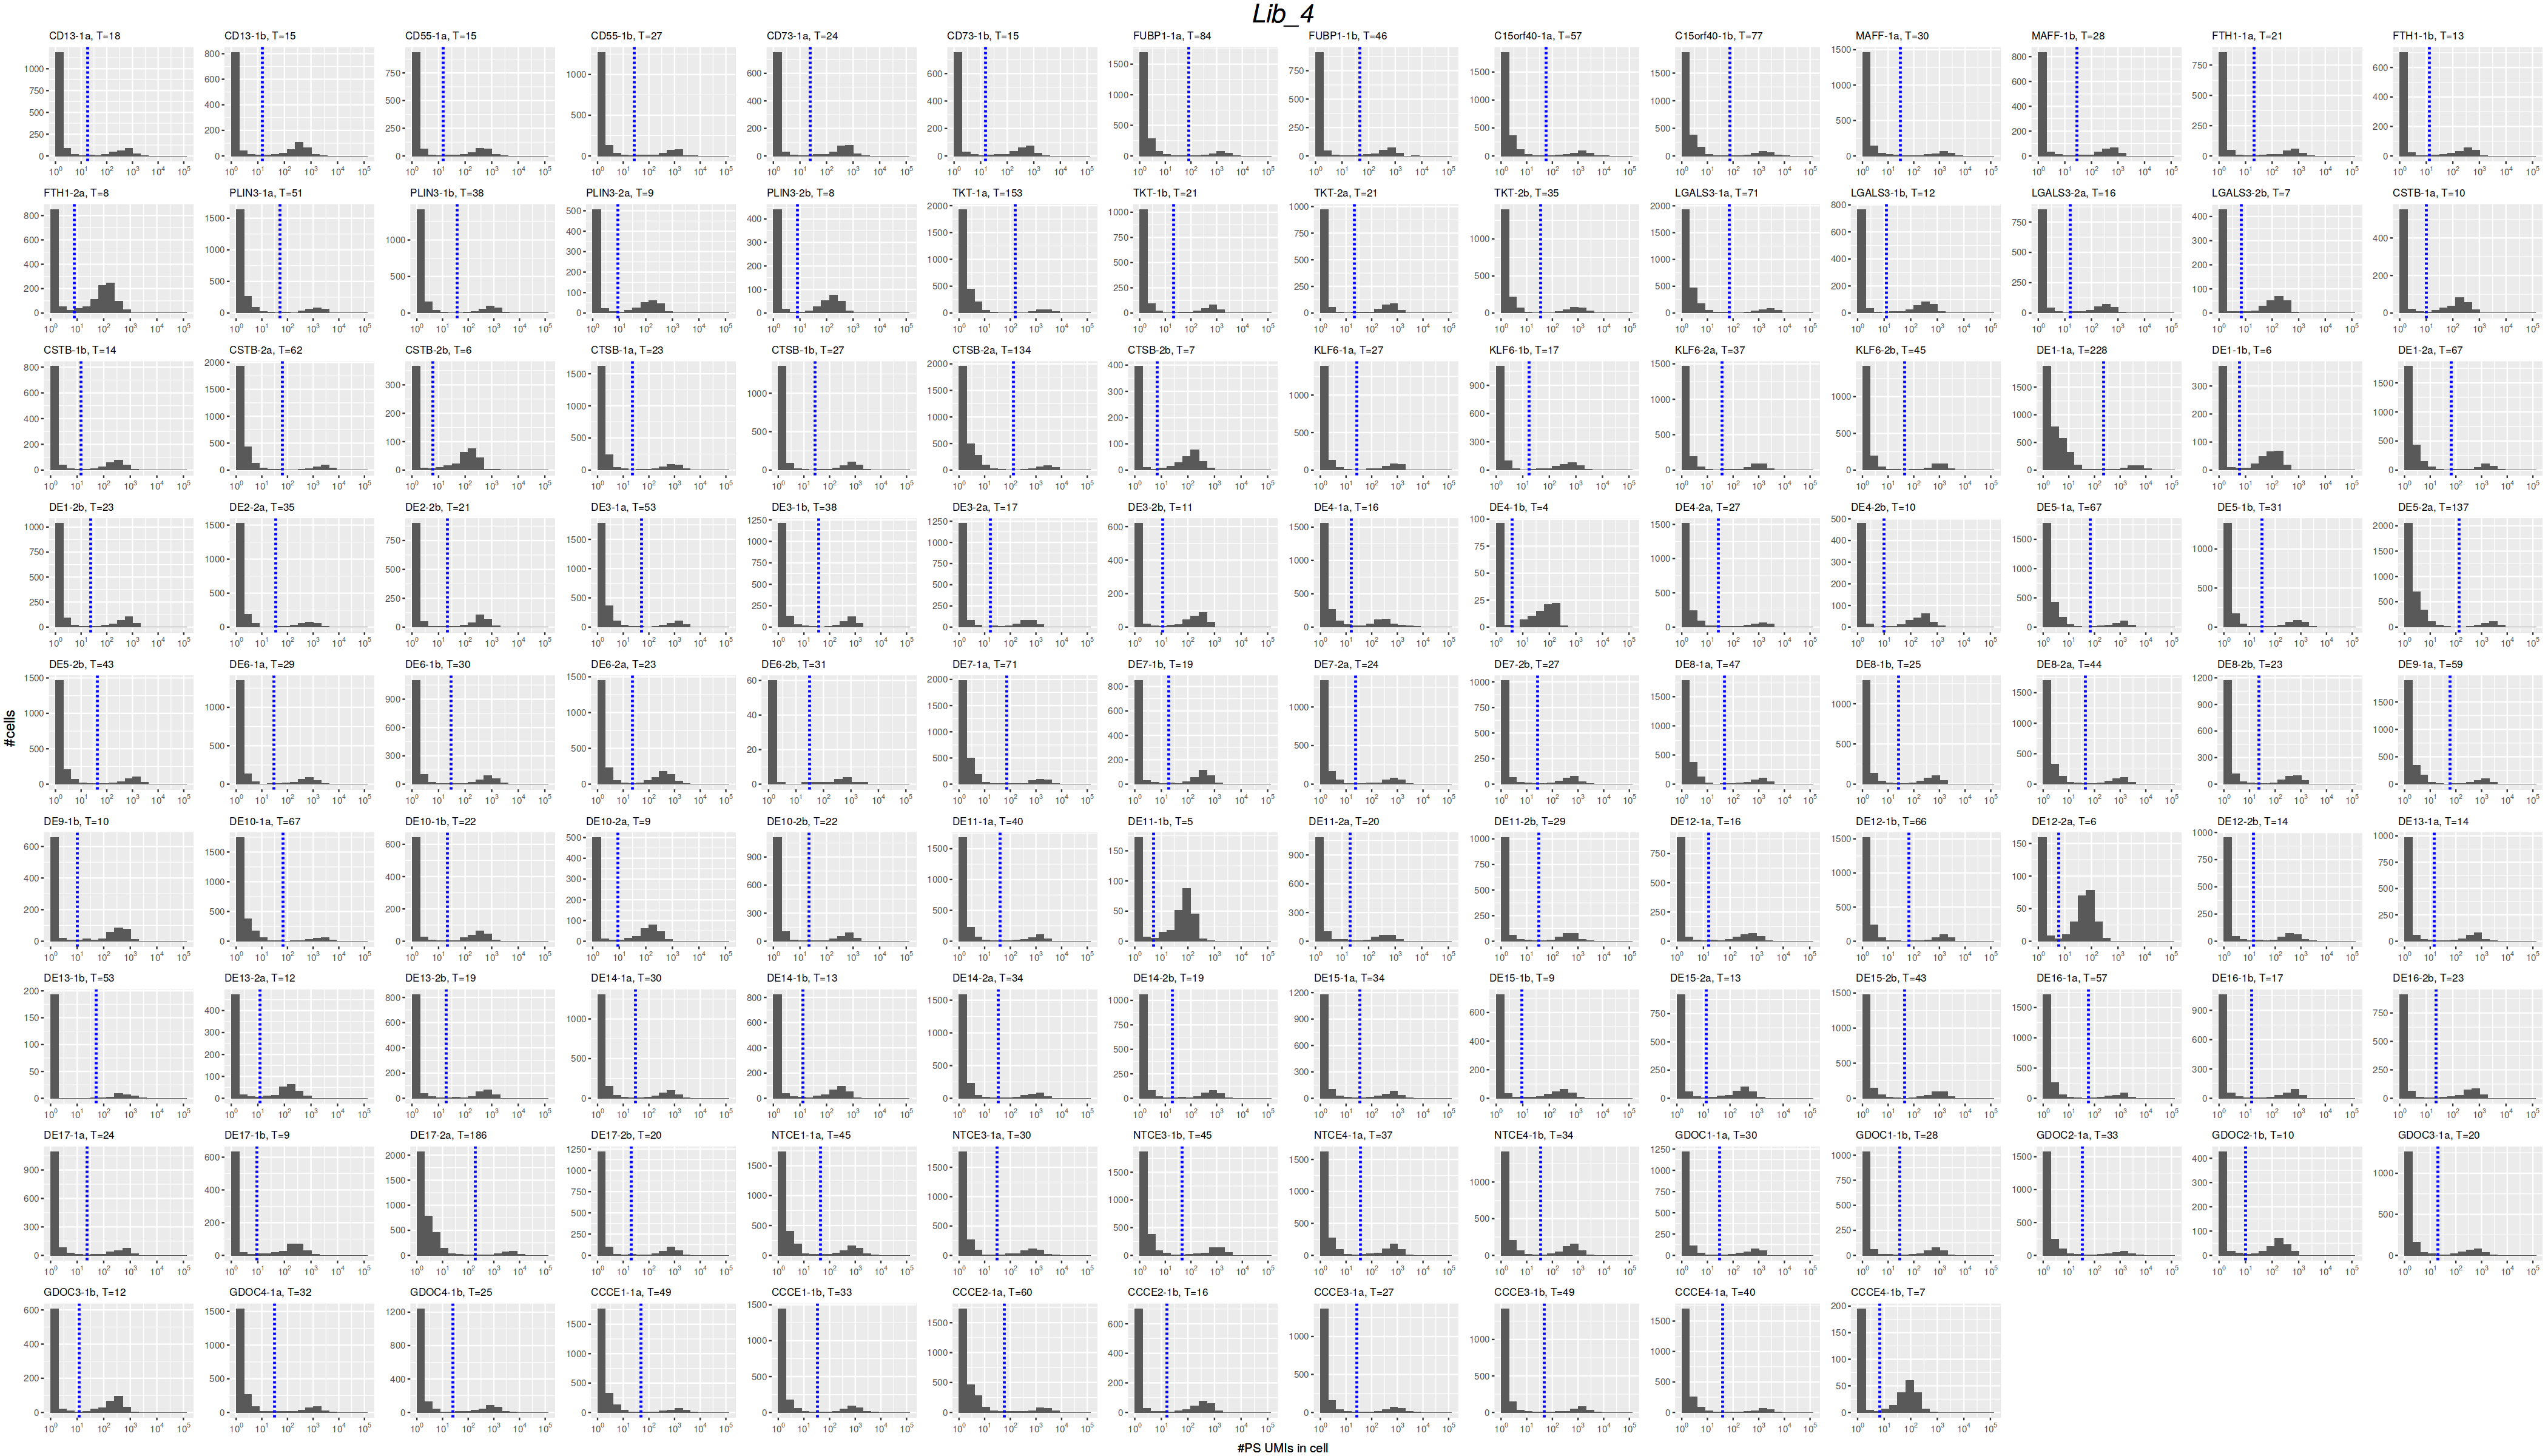

In [18]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"), 
        plt,
        width = 22, 
        height = 17, 
        dpi = 300
    )
}

# Write thresholds to file

In [19]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)

if(save_seurat_h5 == "YES") {
    write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)
}

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15


In [20]:
head(df_thresholds)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15


# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [21]:
### Load THRESHOLDS.tsv
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS


### Get the list of pertubed cells for each guide

In [22]:
perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds)

In [23]:
df_calls = enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls = as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell  <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)

In [24]:
df_calls_wide <- df_calls %>% 
    group_by(cell) %>% 
    summarise(guide_calls = paste(unique(guide), collapse = '|'), plasmid_calls = paste(unique(plasmid), collapse = '|'))

In [25]:
df_calls_wide$n_guides   <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide = as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL

In [44]:
head(df_calls_wide,20)

,guide_calls,plasmid_calls,n_guides,n_plasmids
,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3
AAACCCAAGCCATTTG-1_4,CD55-1b|DE2-2a,CD55-1|DE2-2,2,2
AAACCCAAGCCGATAG-1_4,NTCE1-1a,NTCE1-1,1,1
AAACCCAAGCTTAAGA-1_1,CD13-1a|CD13-1b|DE3-2a|DE3-2b|CCCE3-1b,CD13-1|DE3-2|CCCE3-1,5,3
AAACCCAAGGAACTAT-1_3,FTH1-2a|DE7-1a|DE7-1b|DE8-2a|DE8-2b|DE14-1a|DE14-1b|DE14-2a|DE14-2b,FTH1-2|DE7-1|DE8-2|DE14-1|DE14-2,9,5
AAACCCAAGGCTGTAG-1_1,TKT-1a|TKT-1b,TKT-1,2,1
AAACCCACAAGCTCTA-1_4,DE5-1b|DE12-1a|DE12-1b|CCCE1-1a,DE5-1|DE12-1|CCCE1-1,4,3
AAACCCACATCCGGTG-1_4,DE16-2b|GDOC3-1a,DE16-2|GDOC3-1,2,2


### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [27]:
cols2rename = c('PS_call', 'construct_call', 'target_call', 'nCalled_Constructs', 'nPS_calls', 'nCalled_sgRNA_UMIs')
df_dummy = seurat_combined@meta.data
for(i in 1:length(cols2rename)) {
    colname = cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0('cellranger_', colname) 
}
df_dummy = merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
seurat_combined@meta.data = df_dummy

In [28]:
nrow(seurat_combined@meta.data)
nrow(df_dummy)

[1] 21363

[1] 21363

In [29]:
head(seurat_combined,2)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,cellranger_PS_call,⋯,cellranger_nPS_calls,cellranger_nCalled_sgRNA_UMIs,status,donor,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25177,5887,3237,19,26187,5837,Screen1_66guides,Lib_1,6.7,FUBP1_1a|DE6_2a|DE8_1a|DE8_1b|DE15_2b,⋯,5,941|248|953|446|628,singlet,3,0,0,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,10230,3697,8236,49,24575,4484,Screen1_66guides,Lib_3,5.7,DE14_2b|NTCE1_1a|GDOC4_1a,⋯,3,2994|1067|4097,singlet,3,1,1,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3


### Save the updated Seurat object

In [30]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined, integrated_h5_path, overwrite = T, verbose = F)
}

# Visualizations using the PG guide-called data

### Constructs per cell distribution

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


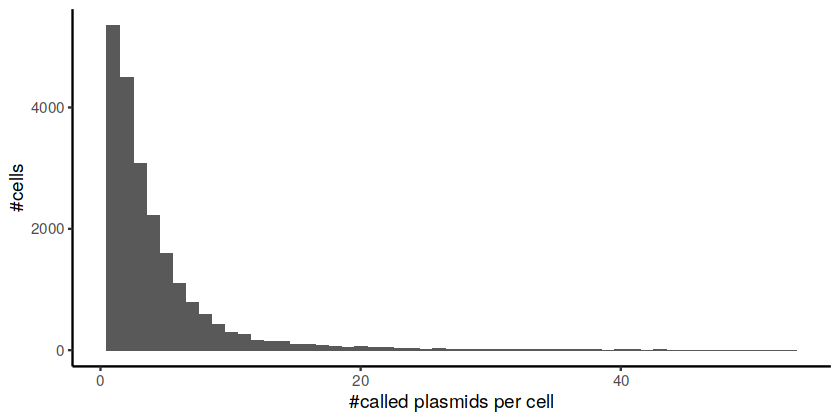

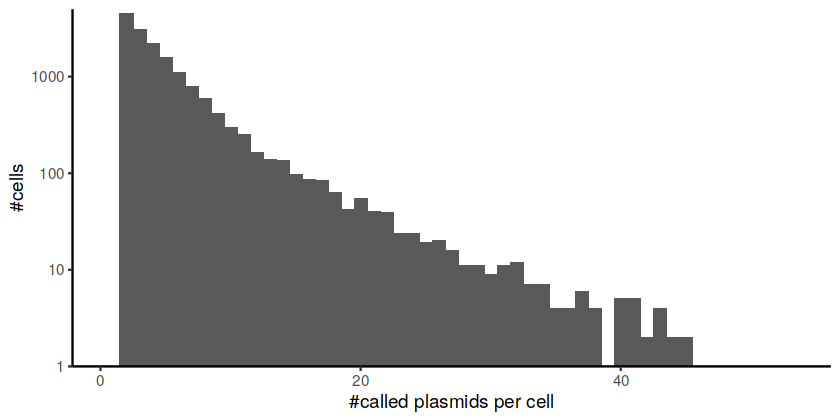

In [31]:
p5 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") + 
    theme_classic() 

p6 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    scale_y_log10(limits = c(1, 5000), expand = c(0, 0)) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic() 

options(repr.plot.width=7, repr.plot.height=3.5)
p5
p6

### Plot cells per plasmid distribution

In [32]:
plasmid_calls = seurat_combined@meta.data$plasmid_calls
plasmid_calls = str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy = as.data.frame(table(plasmid_calls))
df_dummy$plasmid_calls = as.character(df_dummy$plasmid_calls)
df_dummy[df_dummy$plasmid_calls == "NA", 'plasmid_calls'] = " No Plasmid"

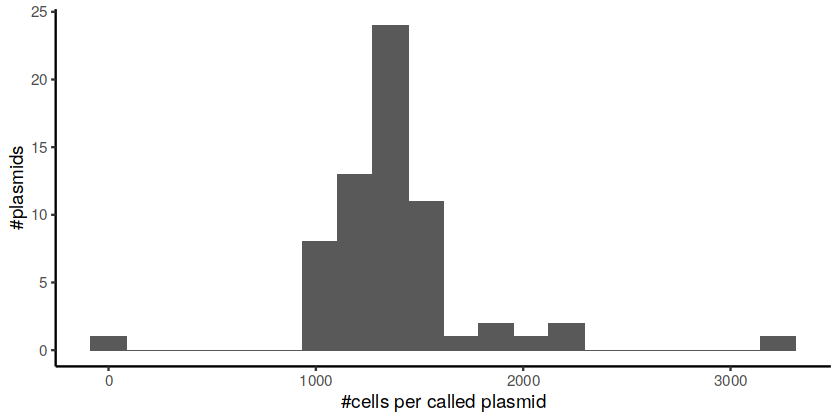

In [33]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    theme_classic() 
    

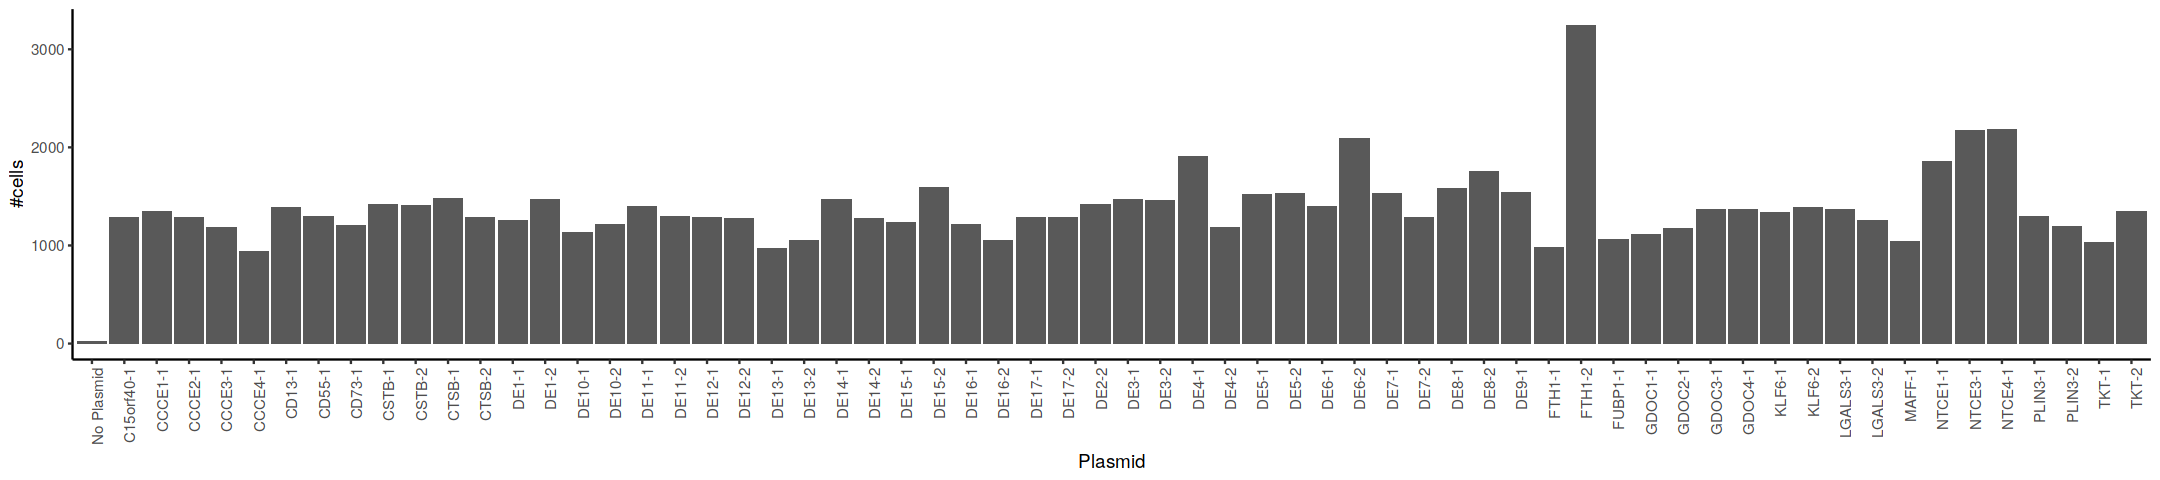

In [47]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6